The preprocessing for this data set is quite simple, as the dataset already contains tags_tokenized to eliminate unnecesary words from the data set. Additionally, all numerical values are already scaled between 1 and 0

In [1]:
print("hello world")
import datasets
from datasets import load_dataset


dataSet = load_dataset('csv',data_files='songs.csv')

print(dataSet)



hello world


c:\Users\colez\anaconda3\envs\cosc410\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_release_date', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_artist_merged', 'lyrics', 'artist_name', 'tags', 'tags_tokenized', 'doc_vector', 'combined_vector', 'cluster', 'image_url', 'spotify_url'],
        num_rows: 900
    })
})


In [3]:
def classify_popularity(examples):
    try:
        track_popularity = float(examples['track_popularity']) 
    except ValueError:
        track_popularity = float('nan')  
    if track_popularity < 0.15:
        return {'label': 0}
    elif 0.15 <= track_popularity < 0.5:
        return {'label': 1}
    elif track_popularity >= 0.5:
        return {'label': 2}
    else:
        return {'label': 'unknown'}  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

df = pd.read_csv("songs.csv")

 #uses same thresholds as the distilBert
def classify_popularity(popularity_score):
    if popularity_score < 0.1:
        return 0
    elif popularity_score < 0.3:
        return 1
    else:
        return 2


df['popularity_class'] = df['track_popularity'].apply(classify_popularity)


print(df[['track_popularity', 'popularity_class']].head())

   track_popularity  popularity_class
0          0.500000                 2
1          0.318182                 2
2          0.318182                 2
3          0.227273                 1
4          0.409091                 2


Accuracy: 43.33%
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.93      0.60        76
           1       0.43      0.05      0.09        60
           2       0.31      0.09      0.14        44

    accuracy                           0.43       180
   macro avg       0.39      0.36      0.28       180
weighted avg       0.41      0.43      0.32       180



c:\Users\colez\anaconda3\envs\cosc410\lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


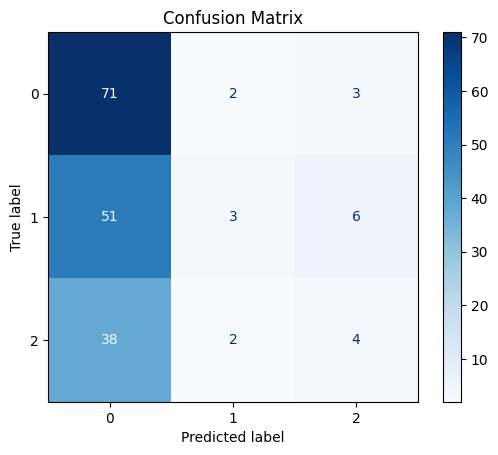

In [ ]:
X = df[['danceability','energy','key', 'loudness', 'tempo', 'speechiness', 'acousticness','liveness','valence',]] 
y = df['popularity_class'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model = LogisticRegression(max_iter=10000, multi_class='ovr', solver='liblinear')


model.fit(X_train, y_train)

y_pred = model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


print("Classification Report:")
print(classification_report(y_test, y_pred))


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Mean Squared Error: 0.04120452091554345
R-squared: 0.03579285076320193
Coefficients: [ 0.07264406 -0.22648524  0.0575644   0.20785369  0.05183294  0.03050886
  0.00708823  0.04380922 -0.0299633 ]
Intercept: 0.1011279427583392


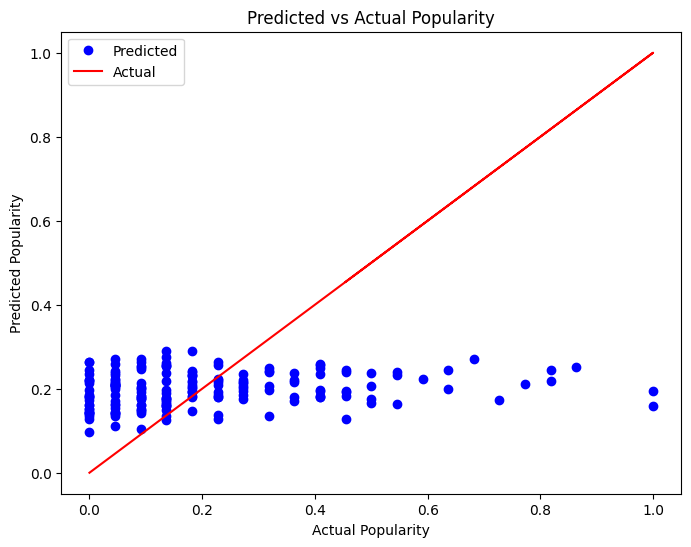

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y = df['track_popularity']

# split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

plt.figure(figsize=(8,6))
plt.plot(y_test, y_pred, 'bo', label='Predicted')
plt.plot(y_test, y_test, 'r-', label='Actual')  
plt.title('Predicted vs Actual Popularity')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.show()

In [ ]:
from collections import Counter
import numpy as np


def extract_features(df):
    features = []

    for idx, row in df.iterrows():
        lyrics = row['lyrics'] 

        #1) number words in lyrics
        num_lyrics = len(lyrics)

        #2) number of repeated words
        token_counts = Counter(lyrics)
        repeated_tokens = sum(1 for count in token_counts.values() if count > 1)

        #3) longest stretch of repeated words
        max_stretch = 0
        current_stretch = 1
        for i in range(1, len(lyrics)):
            if lyrics[i] == lyrics[i - 1]:
                current_stretch += 1
            else:
                max_stretch = max(max_stretch, current_stretch)
                current_stretch = 1
        max_stretch = max(max_stretch, current_stretch)

        #4) highest frequency of a word in the lyrics
        highest_frequency = max(token_counts.values())

        features.append([num_lyrics, repeated_tokens, max_stretch, highest_frequency, row['track_popularity'], row['popularity_class']])

    feature_df = pd.DataFrame(features, columns=['num_lyrics', 'repeated_tokens', 'max_stretch', 'highest_frequency', 'track_popularity', 'popularity_class'])

    return feature_df

df_features = extract_features(df)
print(df_features.head(200))

     num_lyrics  repeated_tokens  max_stretch  highest_frequency  \
0          2886               29            2                760   
1         10068               33            2               2702   
2          2531               31            2                666   
3          2671               32            2                699   
4          8600               31            2               2170   
..          ...              ...          ...                ...   
195        3301               30            2                875   
196        3710               27            2               1042   
197        9791               31            2               2524   
198        6624               29            2               1640   
199        4114               29            2               1041   

     track_popularity  popularity_class  
0            0.500000                 2  
1            0.318182                 2  
2            0.318182                 2  
3            0.

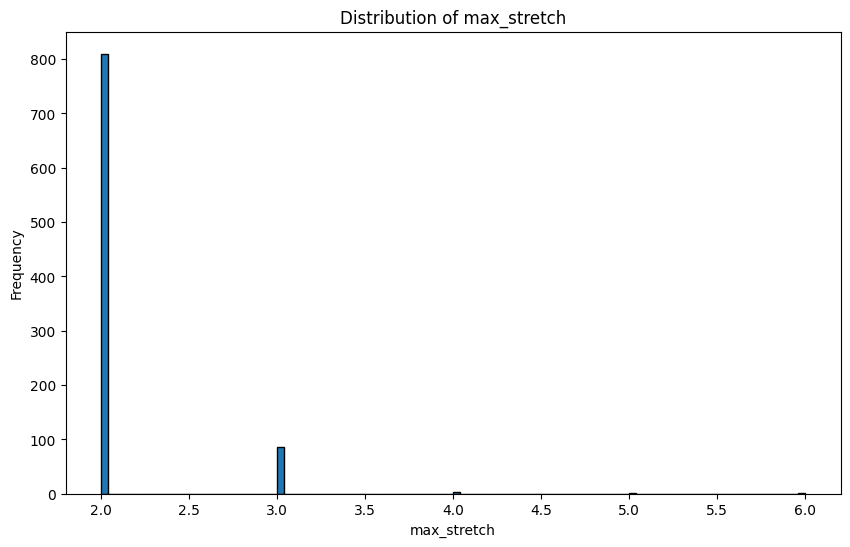

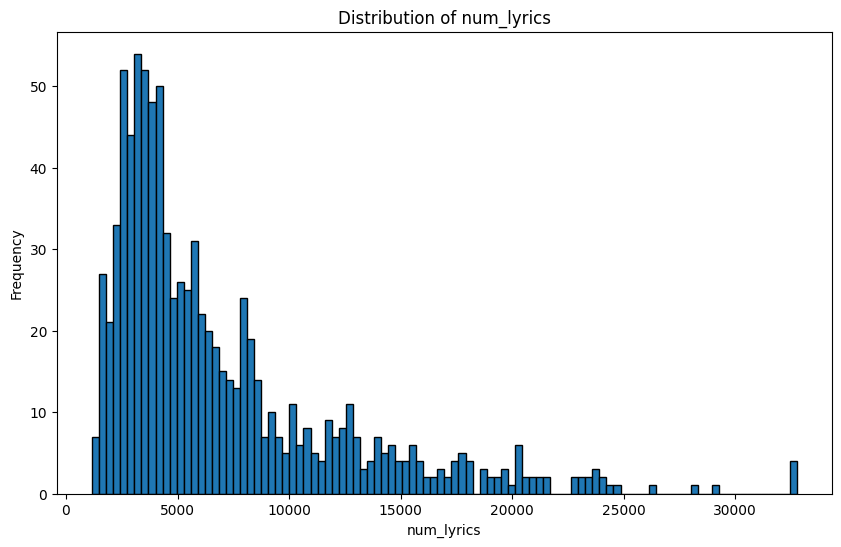

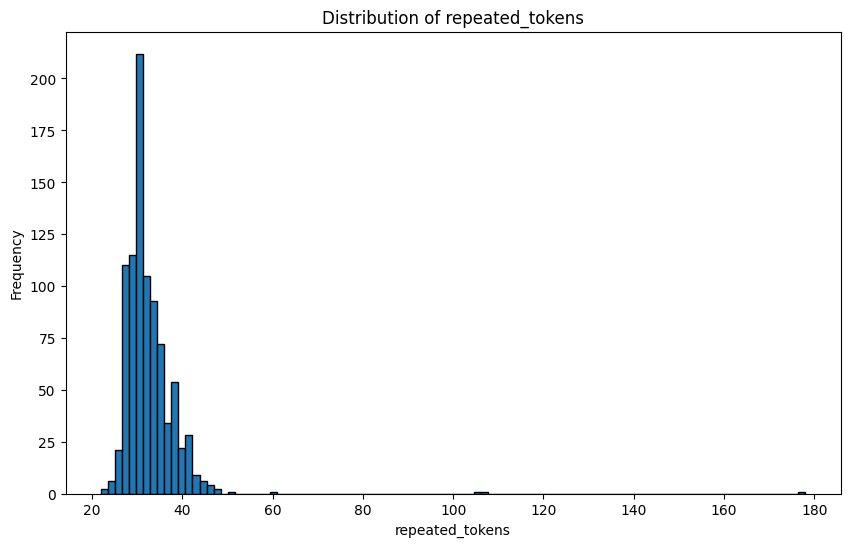

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df_features['max_stretch'], bins=100, edgecolor='black')
plt.title('Distribution of max_stretch')
plt.xlabel('max_stretch')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 6))
plt.hist(df_features['num_lyrics'], bins=100, edgecolor='black')  
plt.title('Distribution of num_lyrics')
plt.xlabel('num_lyrics')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df_features['repeated_tokens'], bins=100, edgecolor='black')  
plt.title('Distribution of repeated_tokens')
plt.xlabel('repeated_tokens')
plt.ylabel('Frequency')
plt.show()

In [44]:
from transformers import AutoTokenizer

def tokenize_data(dataset, modelname):
    tokenizer = AutoTokenizer.from_pretrained(modelname)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding = 'max_length', truncation= True)
    return dataset.map(tokenize_function, batched = True)

In [45]:
def concatenate(dataset):
    dataset['text'] = '[CLS]' + dataset['lyrics'] + ' [SEP]'
    return dataset

In [46]:
dataSet = dataSet.map(classify_popularity, batched=False)
#print(dataSet['train'].column_names)
#print(dataSet['test'].column_names)
# df = dataSet['train'].to_pandas()

# Print the first few rows of interest (popularity_class)
#print(df[['track_popularity', 'popularity_class']].head(50))
model_name = 'distilbert-base-multilingual-cased'



dataset_train = dataSet['train'].select(range(720))
dataset_test = dataSet['train'].select(range(721, len(dataSet['train'])))

ds_train = dataset_train.map(concatenate)
ds_test = dataset_test.map(concatenate)

# print(ds_test['text'][100])
# print(ds_test['popularity_class'][100])


Map: 100%|██████████| 179/179 [00:00<00:00, 3004.36 examples/s]


In [47]:
ds_train = tokenize_data(ds_train, model_name)
ds_test = tokenize_data(ds_test, model_name)

dd = datasets.DatasetDict({"train":ds_train, "test":ds_test})
print(ds_train.column_names)

Map: 100%|██████████| 179/179 [00:00<00:00, 717.92 examples/s]

['Unnamed: 0', 'track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_release_date', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_artist_merged', 'lyrics', 'artist_name', 'tags', 'tags_tokenized', 'doc_vector', 'combined_vector', 'cluster', 'image_url', 'spotify_url', 'label', 'text', 'input_ids', 'attention_mask']


In [48]:
import torch
def get_predictions(model, data):
    """ Get predictions on data for a classification model m returning predictions and true labels"""
    model.eval()
    model.to('cpu')
    predictions = model(torch.tensor(data['input_ids']), torch.tensor(data['attention_mask']))
    predictions = torch.argmax(predictions.logits, dim=-1)
    return predictions, torch.tensor(data['label'])

In [ ]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
y_hat, y = get_predictions(model, dd["train"][0])

print(accuracy_score(y_hat,y))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 